<a href="https://colab.research.google.com/github/delhian/ComputerVision/blob/main/%5DHome%20Tasks/HT1_block_sf_unet_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальное задание по теме обработки изображений
В этом задании вы напишете класс Dataset для задачи сегментации. 

В папке Train_Data находятся изображения. В input — картинки с котиками, в mask — маски изображений. Критерий правильно написанного класса — у вас запустилось обучение.

Датасет небольшой, поэтому не удивляйтесь, что сегментация будет не очень точной, но отрисуйте пару сегментированных котиков. 

Для начала скачайте датасет и положите его на свой Google-диск. 

# Загрузка датасета

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Разархивируем наш датасет

In [ ]:
!unzip -oq /content/gdrive/MyDrive/Train_Data.zip

Импортируем нужные библиотеки

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

Для решения задачи сегментации будем использовать известную архитектуру Unet.

# UNet архитектура

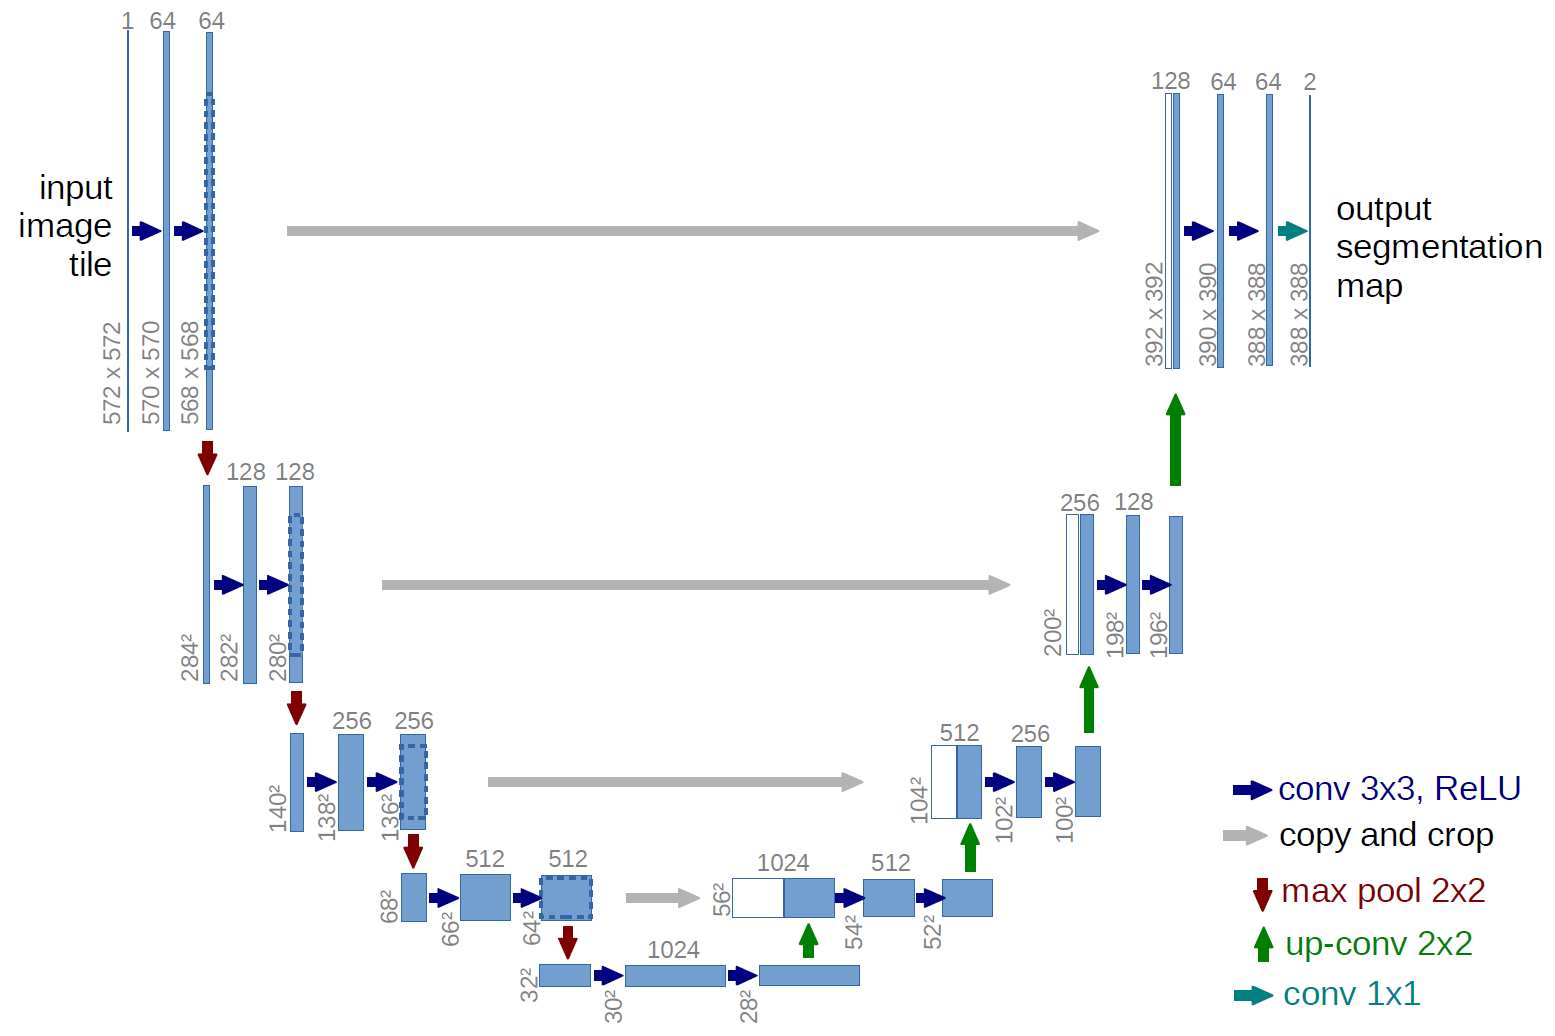

Архитектура UNet используется для сегментации картинок и представляет собой сверточную нейросеть.

Так выглядит архитектура UNet, реализованная в виде кода.

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Это была общая архитектура. Подробнее об ней вы можете прочитать [здесь](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

Теперь необходимо реализовать отдельные ее блоки.

DoubleConv — блок, состоящий из повторяющихся друг за другом последовательностей конволюция -> нормализация по батчам -> активация ReLU.

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

Down — один шажок Downsampling, или понижения размерности. Состоит из пулинга и представленной выше двойной конволюции.

In [6]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

Up — обратная операция, повышение размерности.

In [7]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс Dataset

Реализуйте свой класс DataSet

In [8]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomApply(
            torch.nn.ModuleList([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]), p = 0.5),
        transforms.Resize([256, 256]),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

mask_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([256, 256])
        ])

In [9]:
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, path_to_masks, data_transforms, mask_transforms):
        ### PUT YOUR CODE HERE ###
        self.path_to_images = path_to_images
        self.image_paths = os.listdir(self.path_to_images)
        self.path_to_masks = path_to_masks
        self.mask_paths = os.listdir(self.path_to_masks)
        self.data_transforms = data_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__ (self, idx):
        ### PUT YOUR CODE HERE ###

        image_fname = self.image_paths[idx]
        image_path = os.path.join(self.path_to_images, image_fname)
        data = Image.open(image_path)
        data = self.data_transforms(data)
        data = torch.FloatTensor(data)

        mask_fname = 'mask_'+ image_fname
        mask_path = os.path.join(self.path_to_masks, mask_fname)
        target = Image.open(mask_path)
        target = self.mask_transforms(target)
        target = torch.FloatTensor(target)

        return (data, target)
              
train_dataset = my_dataset('/content/Train_Data/input',
                           '/content/Train_Data/mask',
                           data_transforms = data_transforms,
                           mask_transforms= mask_transforms)
    
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

torch.Size([3, 256, 256])


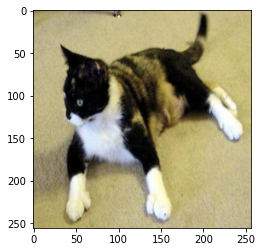

torch.Size([1, 256, 256])


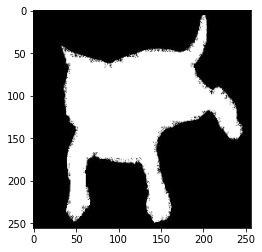

In [10]:
ix = 56

print(train_dataset[ix][0].shape)
plt.imshow(train_dataset[ix][0].permute(1, 2, 0))
plt.show()
print(train_dataset[ix][1].shape)
plt.imshow(train_dataset[ix][1].numpy().squeeze(), cmap='gray')

# Обучение модели

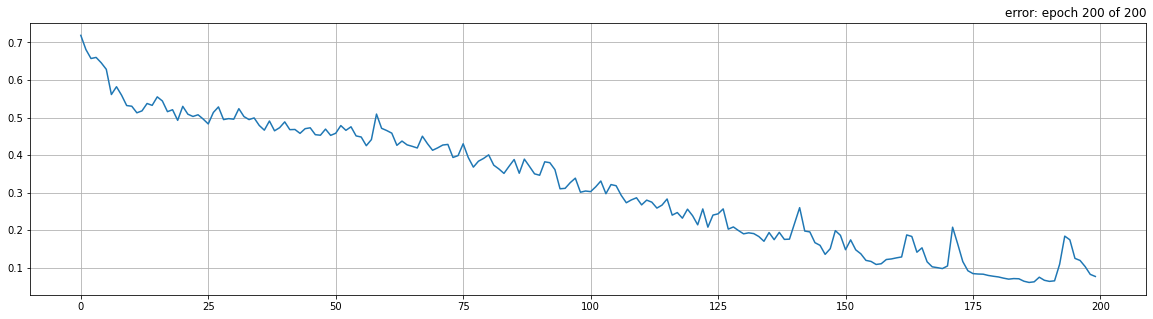

In [16]:
learning_rate = 0.001

import time
from IPython.display import clear_output
model = UNet(n_channels=3, n_classes = 1);#UNet(n_class = 2);
model.cuda()
opt = torch.optim.Adam(model.parameters() , lr = learning_rate)

num_epochs = 200
train_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True)
    error_mean = []
    for (X_batch, y_batch) in train_batch_gen:
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        # print(model(X_batch).shape)
        loss = nn.BCEWithLogitsLoss()(model(X_batch), y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        error_mean.append(loss.item())
    
    train_loss.append(np.mean(error_mean))
    clear_output(True)
    plt.figure(figsize = (20,5))
    plt.plot(train_loss)
    plt.grid()
    plt.title(f'error: epoch {epoch + 1} of {num_epochs}', loc='right')
    plt.show()

# Оценка результатов

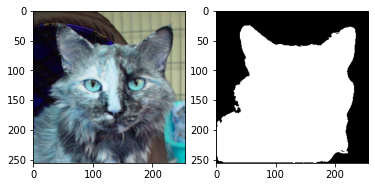

In [17]:
im = cv2.imread('/content/Train_Data/input/cat.10.jpg')
im = cv2.resize(im, (256, 256))
plt.subplot(121)
plt.imshow(im)

im = torch.FloatTensor(im)

a = model.forward(im.permute(2, 0, 1)[None, :].cuda()).squeeze().detach().cpu()
a = torch.nn.Sigmoid()(a).numpy()
plt.subplot(122)
plt.imshow(a>0.5, cmap='gray')